# Evaluate S2 Geomedian

3-month, 6-month and annual geomedians have been generated for selected locations. These are assessed for:

1. missing pixel percentage
2. ability to seperate temporal behavior of pixels within agiculture areas


In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os, glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pyproj import Transformer

import datacube


In [2]:
dc = datacube.Datacube()

## missing pixel percentage

In [3]:
import pandas as pd

In [4]:

def gm_stats(path, get_ls=True, redo=False, buffer=0):
    output = '_'.join(path.split('/'))+f'_buffer{buffer}.csv'
    if os.path.exists(output) and (not redo):
        df = pd.read_csv(output)
        return df
    
    files = [f for f in glob.glob(f"{path}/s2_2017-01-01_2017-03-31_*_*.nc") if 'buffer' not in f]
    
    rows= []
    for f1 in files:
        parts = f1.split('/')[-1].split('.')[0].split('_')
        x0, y0 = int(parts[-2]), int(parts[-1])
    
        if buffer==0:
            filenames = glob.glob(f"{path}/s2_????-??-??_????-??-??_{x0}_{y0}.nc")
        else:
            filenames = glob.glob(f"{path}/s2_????-??-??_????-??-??_{x0}_{y0}_buffer{buffer}.nc")
        filenames.sort()
        if len(filenames)==0:
            continue
            
        if get_ls:
            data = xr.open_dataset(filenames[0])
            x = data.x.values[0], data.x.values[3]
            y = data.y.values[-1], data.y.values[4]
            ls = dc.load(product='ga_ls8c_gm_2_annual', crs="EPSG:6933", time="2018", x=x, y=y,
                         measurements=['swir_1','nir','green','blue','red']).squeeze()
            ls = ls.where(ls>0)*2.75e-5 -0.2
            ls_missing_frac = ls.red.isnull().mean().values

        for i, f in enumerate(filenames):
            location = '_'.join(f.split('/')[-1].split('.')[0].split('_')[3:5])
            start = f.split('/')[-1].split('.')[0].split('_')[1]
            end = f.split('/')[-1].split('.')[0].split('_')[2]
            data = xr.open_dataset(f)
            missing_frac = data.red.isnull().mean().values
            nobs = data.attrs['nobs']

            row = pd.DataFrame({'location':[location],'input_maxcloud':[data.attrs['cloud_cover']], 'start':[start], 'end':[end], 
                                'ls_2018_missing_frac':[ls_missing_frac],
                                'nobs':[nobs], 'missing_frac':[missing_frac]})
            rows.append(row)
            
    df = pd.concat(rows, ignore_index=True)
    df['length_month'] = np.round((df.end.astype(np.datetime64) - df.start.astype(np.datetime64))/np.timedelta64(30,'D')).astype(int)
    df['missing_perc'] = df.missing_frac*100
    df['ls_2018_missing_perc'] = df.ls_2018_missing_frac*100
    
    df.to_csv(output, index=False)
    return df

In [5]:
path = "s2_geomedian/cloud_cover_0_40"
df_0_40_buffer0 = gm_stats(path, get_ls=True, redo=False, buffer=0)
path = "s2_geomedian/cloud_cover_0_60"
df_0_60_buffer0 = gm_stats(path, get_ls=True, redo=False, buffer=0)
#df_0_60_buffer10 = gm_stats(path, get_ls=True, redo=False, buffer=10)
path = "s2_geomedian/cloud_cover_0_100"
df_0_100_buffer0 = gm_stats(path, get_ls=True, redo=False, buffer=0)
df_0_100_buffer10 = gm_stats(path, get_ls=True, redo=False, buffer=10)


In [6]:
df_0_100_buffer0.location.unique()

array(['1235024_-293341', '1900779_-4114302', '1273618_-979438',
       '2441102_-2585134', '318404_840172', '2836696_-395289',
       '3367371_-1168770', '3007477_3658789'], dtype=object)

In [7]:
#df_0_60_buffer0

## plot missing percentage

In [8]:
areas = {'2836696_-395289': 'Buruni',
         '318404_840172':'Lagos, Nigeria',
         '2441102_-2585134': 'Salt pan, Botswana',
         '1235024_-293341': 'Congo/Gabon',
         '1900779_-4114302': 'South Africa',
         '3007477_3658789': 'Cairo',
         '1273618_-979438': 'Agola',
         '3367371_-1168770': 'Tanzania',
        }

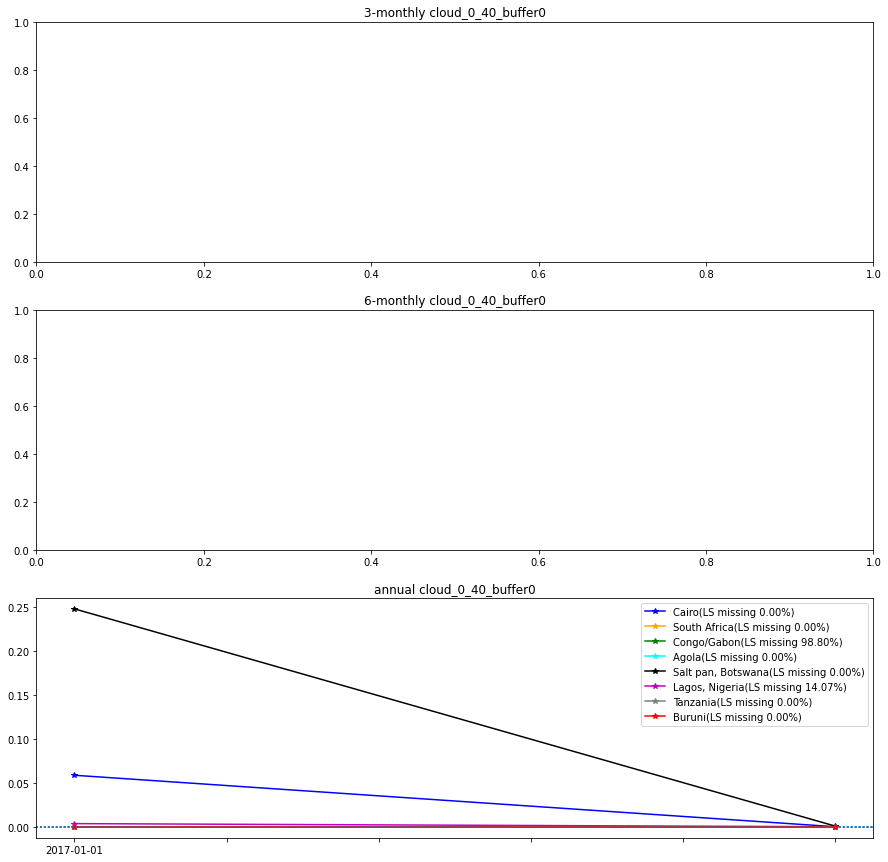

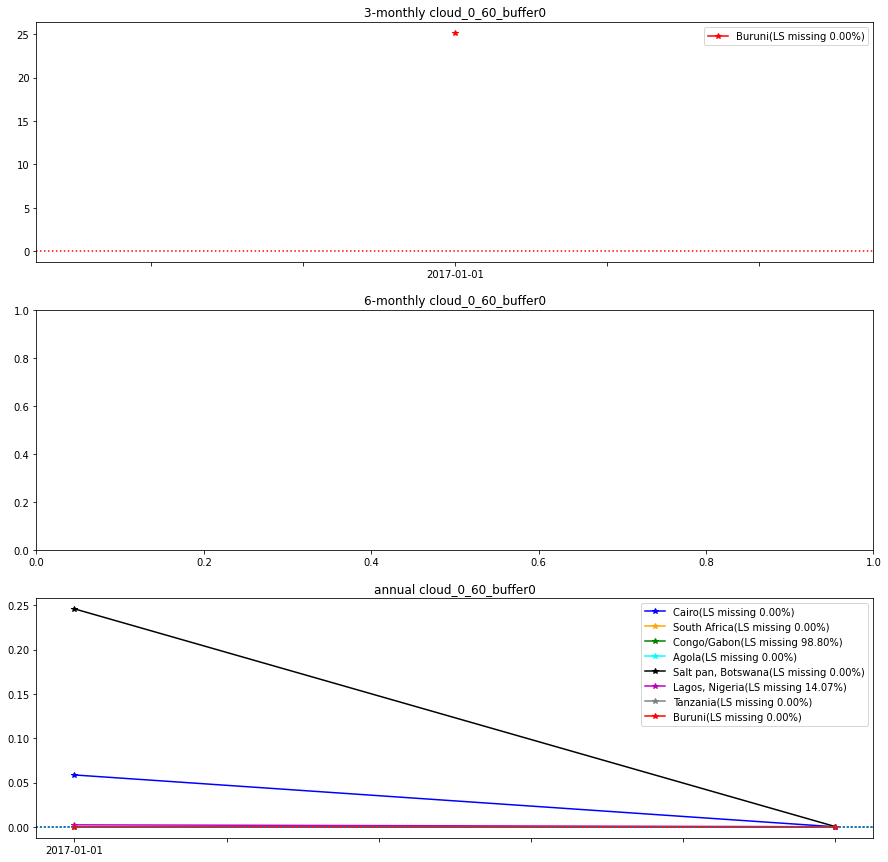

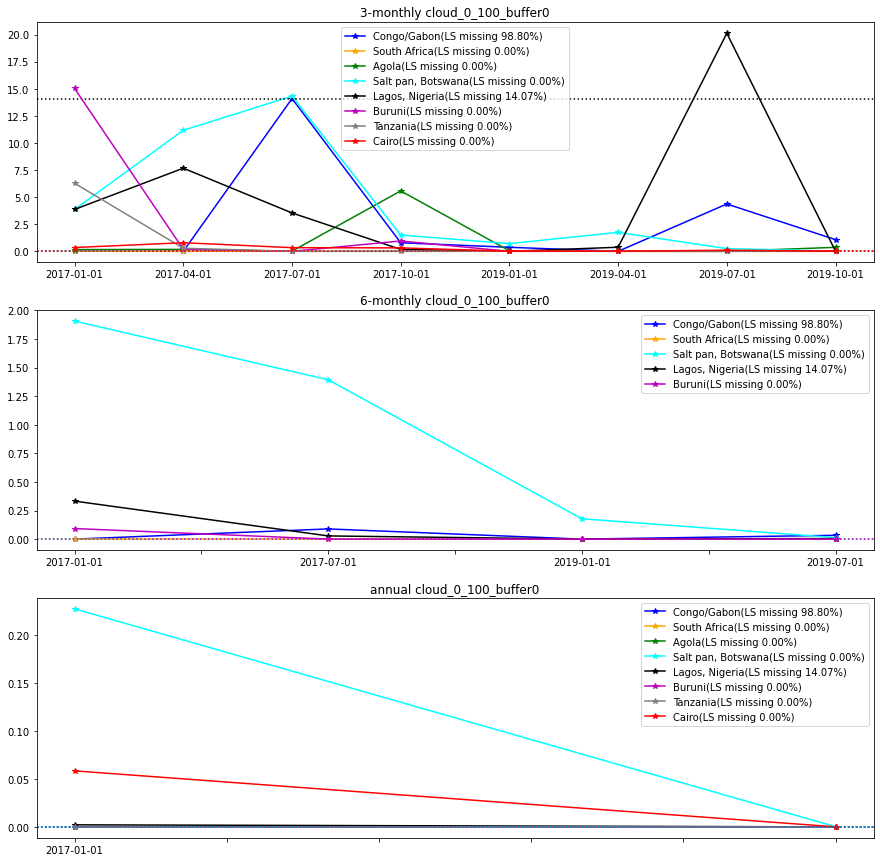

In [9]:

def plot_missing_perc(df_all, figname):
    f, ax  = plt.subplots(3,1,figsize=(15,15))
    
    colors=['b','orange','g','cyan', 'k', 'm', 'grey','red']
    for i, l in enumerate(df_all.location.unique()):
        df = df_all.loc[df_all.location==l]
        name = areas[l] + f'(LS missing {df.ls_2018_missing_perc.values[0]:.2f}%)'
        if len(df.loc[df.length_month==3])>0:
            df.loc[df.length_month==3][['start','missing_perc']].plot(x='start',y='missing_perc', ax=ax[0], label=name, marker='*', color=colors[i])
            if df.ls_2018_missing_perc.values[0]<= df.loc[df.length_month==3].missing_perc.values.max(): ax[0].axhline(df.ls_2018_missing_perc.values[0], ls=":", color=colors[i])
        if len(df.loc[df.length_month==6])>0:
            df.loc[df.length_month==6][['start','missing_perc']].plot(x='start',y='missing_perc', ax=ax[1], label=name, marker='*', color=colors[i])
            if df.ls_2018_missing_perc.values[0]<= df.loc[df.length_month==6].missing_perc.values.max(): 
                ax[1].axhline(df.ls_2018_missing_perc.values[0], ls=":", color=colors[i])
        if len(df.loc[df.length_month==12])>0:
            df.loc[df.length_month==12][['start','missing_perc']].plot(x='start',y='missing_perc', ax=ax[2], label=name, marker='*', color=colors[i])
            if df.ls_2018_missing_perc.values[0]<= df.loc[df.length_month==12].missing_perc.values.max(): 
                ax[2].axhline(df.ls_2018_missing_perc.values[0], ls=":")

    ax[0].set_xlabel('');
    ax[1].set_xlabel('');
    ax[2].set_xlabel('');
  
    ax[0].set_title('3-monthly '+ figname.split('/')[-1].split('.')[0]);
    ax[1].set_title('6-monthly '+ figname.split('/')[-1].split('.')[0]);
    ax[2].set_title('annual '+ figname.split('/')[-1].split('.')[0]);

    f.savefig(figname)

plot_missing_perc(df_0_40_buffer0, 'cloud_0_40_buffer0.png')
plot_missing_perc(df_0_60_buffer0, 'cloud_0_60_buffer0.png')
#plot_missing_perc(df_0_60_buffer10, 'cloud_0_60_buffer10.png')
plot_missing_perc(df_0_100_buffer0, 'cloud_0_100_buffer0.png')
#plot_missing_perc(df_0_100_buffer10, 'cloud_0_100_buffer10.png')


## temporal features

In [ ]:
from sklearn.decomposition import PCA
import sys
sys.path.append('../Scripts')
from deafrica_classificationtools import sklearn_flatten, sklearn_unflatten

In [ ]:
# 2019 seasonal

xy = '1900779_-4114302'
xy = '318404_840172'
#xy = '1273618_-979438'
#xy = '3367371_-1168770'
buffer = 10

if buffer ==0:
    images = [#'s2_geomedian/cloud_cover_0_100/s2_2017-01-01_2017-03-31_2836696_-395289.nc',
          #'s2_geomedian/cloud_cover_0_100/s2_2017-04-01_2017-06-30_2836696_-395289.nc',
          #'s2_geomedian/cloud_cover_0_100/s2_2017-07-01_2017-09-30_2836696_-395289.nc',
          #'s2_geomedian/cloud_cover_0_100/s2_2017-10-01_2017-12-31_2836696_-395289.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-01-01_2019-03-31_{xy}.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-04-01_2019-06-30_{xy}.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-07-01_2019-09-30_{xy}.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-10-01_2019-12-31_{xy}.nc',]
else:
    images = [#'s2_geomedian/cloud_cover_0_100/s2_2017-01-01_2017-03-31_2836696_-395289.nc',
          #'s2_geomedian/cloud_cover_0_100/s2_2017-04-01_2017-06-30_2836696_-395289.nc',
          #'s2_geomedian/cloud_cover_0_100/s2_2017-07-01_2017-09-30_2836696_-395289.nc',
          #'s2_geomedian/cloud_cover_0_100/s2_2017-10-01_2017-12-31_2836696_-395289.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-01-01_2019-03-31_{xy}_buffer{buffer}.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-04-01_2019-06-30_{xy}_buffer{buffer}.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-07-01_2019-09-30_{xy}_buffer{buffer}.nc',
          f's2_geomedian/cloud_cover_0_100/s2_2019-10-01_2019-12-31_{xy}_buffer{buffer}.nc',]


data = xr.concat([xr.open_dataset(im).expand_dims({'time':[np.datetime64(im.split('/')[-1].split('_')[1])]}) for im in images], dim='time')
#data['ndvi'] = (data.nir_2-data.red)/(data.nir_2+data.red)
#ds = data.ndvi.to_dataset(dim='time')

In [ ]:
data[['red','green','blue']].to_array().plot.imshow(col='time',col_wrap=2, robust=True, figsize=(20,20));

In [ ]:
X = sklearn_flatten(ds)
pca = PCA(n_components=3)
pca.fit(X)
print("Relative variance in principal components:", pca.explained_variance_ratio_)
predict = pca.transform(X)
out = sklearn_unflatten(predict, ds)
out = out.to_dataset(dim=out.dims[0]).transpose('y','x')

In [ ]:
out[[2,1,0]].to_array().plot.imshow(figsize=(10,10), robust=True);

In [ ]:
# 2019 6 monthly

images = ['s2_geomedian/cloud_cover_0_100/s2_2019-01-01_2019-06-30_1900779_-4114302.nc',
          's2_geomedian/cloud_cover_0_100/s2_2019-07-01_2019-12-31_1900779_-4114302.nc',]


data = xr.concat([xr.open_dataset(im).expand_dims({'time':[im.split('/')[-1].split('_')[1]]}) for im in images], dim='time')
data['ndvi'] = (data.nir_2-data.red)/(data.nir_2+data.red)
ds = data.ndvi.to_dataset(dim='time')

In [ ]:
varname = list(ds.data_vars)
ds[varname[0]+'dup'] = ds[varname[0]]
varname = list(ds.data_vars)
varname

In [ ]:
ds.to_array().plot.imshow(figsize=(10,10), robust=True);

In [ ]:
# 2017/9 6 monthly

images = ['s2_geomedian/cloud_cover_0_100/s2_2017-01-01_2017-06-30_1900779_-4114302.nc',
          's2_geomedian/cloud_cover_0_100/s2_2017-07-01_2017-12-31_1900779_-4114302.nc',
          's2_geomedian/cloud_cover_0_100/s2_2019-01-01_2019-06-30_1900779_-4114302.nc',
          's2_geomedian/cloud_cover_0_100/s2_2019-07-01_2019-12-31_1900779_-4114302.nc',]


data = xr.concat([xr.open_dataset(im).expand_dims({'time':[np.datetime64(im.split('/')[-1].split('_')[1])]}) for im in images], dim='time')
data['ndvi'] = (data.nir_2-data.red)/(data.nir_2+data.red)
ds = data.ndvi.to_dataset(dim='time')
X = sklearn_flatten(ds)
pca = PCA(n_components=3)
pca.fit(X)
print("Relative variance in principal components:", pca.explained_variance_ratio_)
predict = pca.transform(X)
out = sklearn_unflatten(predict, ds)
out = out.to_dataset(dim=out.dims[0]).transpose('y','x')
out[[2,1,0]].to_array().plot.imshow(figsize=(10,10), robust=True);

## image mosaics

In [ ]:
images = ["s2_geomedian/cloud_cover_0_100/s2_2017-01-01_2017-12-31_3007477_3658789.nc",
          "s2_geomedian/cloud_cover_0_100/s2_2019-01-01_2019-12-31_3007477_3658789.nc"]

data = xr.concat([xr.open_dataset(im).expand_dims({'time':[np.datetime64(im.split('/')[-1].split('_')[1])]}) for im in images], dim='time')

data[['red','green','blue']].to_array().plot.imshow(col='time',col_wrap=2, robust=True, figsize=(20,10));
data[['swir_1', 'nir_2', 'green']].to_array().plot.imshow(col='time',col_wrap=2, robust=True, figsize=(20,10));


In [ ]:
# landsat true/false
# cloud 0-60, buffer =0 
# cloud 0-100, buffer =0

year = 2019
files = [f for f in glob.glob(f"s2_geomedian/cloud_cover_0_100/s2_{year}-01-01_{year}-12-31_*.nc") if not 'buffer' in f]
nf = len(files)

ncol = 2
nrow = nf *4
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20.*nrow/ncol))

true_bands = ['red','green','blue']
false_bands = ['swir_1', 'nir_2', 'green']

for i, f1 in enumerate(files):
    parts = f1.split('/')[-1].split('.')[0].split('_')
    name = areas[parts[-2]+'_'+parts[-1]]
    
    data = xr.open_dataset(f1)
    vmin_t, vmax_t = data[true_bands].to_array().quantile([0.01,0.95]).values
    vmin_f, vmax_f = data[false_bands].to_array().quantile([0.01,0.95]).values
    print("0-100:", vmin_t, vmax_t)
    
    x = data.x.values[0], data.x.values[-1]
    y = data.y.values[-1], data.y.values[0]
    ls = dc.load(product='ga_ls8c_gm_2_annual', crs="EPSG:6933", time="2018", x=x, y=y,
                 measurements=['swir_1','nir','green','blue','red']).squeeze()
    ls = ls.where(ls>0)*2.75e-5 -0.2
    missing_frac = ls.red.isnull().mean().values*100
    ls[['red','green','blue']].to_array().plot.imshow(robust=True, ax=axes[i*4, 0]);
    axes[i*4, 0].set_title(f'{name} - LS true - missing {missing_frac:.3f}%')
    ls[['swir_1','nir','green']].to_array().plot.imshow(robust=True, ax=axes[i*4, 1]);
    axes[i*4, 1].set_title(f'{name} - LS false - missing {missing_frac:.3f}%')

    missing_frac = data.red.isnull().mean().values*100
    nobs = data.attrs['nobs']
    data[true_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+1, 0], vmin=vmin_t, vmax=vmax_t);
    axes[i*4+1, 0].set_title(f'{name} - cloud 0-100 - missing {missing_frac:.3f}% ({nobs} obs)')
    data[false_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+1, 1], vmin=vmin_f, vmax=vmax_f);
    axes[i*4+1, 1].set_title(f'{name} - cloud 0-100 - missing {missing_frac:.3f}% ({nobs} obs)')

    f2 = f1.replace('cloud_cover_0_100', 'cloud_cover_0_60')
    data = xr.open_dataset(f2)
    print("0-60:", data[true_bands].to_array().quantile([0.01,0.95]).values)
    missing_frac = data.red.isnull().mean().values*100
    nobs = data.attrs['nobs']
    data[true_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+2, 0], vmin=vmin_t, vmax=vmax_t);
    axes[i*4+2, 0].set_title(f'{name} - cloud 0-60 - missing {missing_frac:.3f}% ({nobs} obs)')
    data[false_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+2, 1], vmin=vmin_f, vmax=vmax_f);
    axes[i*4+2, 1].set_title(f'{name} - cloud 0-60 - missing {missing_frac:.3f}% ({nobs} obs)')
    
    f2 = f1.replace('cloud_cover_0_100', 'cloud_cover_0_40')
    data = xr.open_dataset(f2)
    print("0-40:", data[true_bands].to_array().quantile([0.01,0.95]).values)
    missing_frac = data.red.isnull().mean().values*100
    nobs = data.attrs['nobs']
    data[true_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+3, 0], vmin=vmin_t, vmax=vmax_t);
    axes[i*4+3, 0].set_title(f'{name} - cloud 0-40 - missing {missing_frac:.3f}% ({nobs} obs)')
    data[false_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+3, 1], vmin=vmin_f, vmax=vmax_f);
    axes[i*4+3, 1].set_title(f'{name} - cloud 0-40 - missing {missing_frac:.3f}% ({nobs} obs)')
    
    
fig.savefig(f'annual_{year}_cloud_0_40_vs_0_60_vs_0_100.png')
    

In [ ]:
# landsat true/false
# cloud 0-60, buffer =0 
# cloud 0-100, buffer =0

year = 2017
files = [f for f in glob.glob(f"s2_geomedian/cloud_cover_0_100/s2_{year}-01-01_{year}-12-31_*.nc") if not 'buffer' in f and not '1235024_-293341' in f]
nf = len(files)

ncol = 2
nrow = nf *4
fig, axes = plt.subplots(nrow, ncol, figsize=(20, 20.*nrow/ncol))

true_bands = ['red','green','blue']
false_bands = ['swir_1', 'nir_2', 'green']

for i, f1 in enumerate(files):
    parts = f1.split('/')[-1].split('.')[0].split('_')
    name = areas[parts[-2]+'_'+parts[-1]]
    
    data = xr.open_dataset(f1)
    vmin_t, vmax_t = data[true_bands].to_array().quantile([0.01,0.95]).values
    vmin_f, vmax_f = data[false_bands].to_array().quantile([0.01,0.95]).values
    print("0-100:", vmin_t, vmax_t)
    
    x = data.x.values[0], data.x.values[-1]
    y = data.y.values[-1], data.y.values[0]
    ls = dc.load(product='ga_ls8c_gm_2_annual', crs="EPSG:6933", time="2018", x=x, y=y,
                 measurements=['swir_1','nir','green','blue','red']).squeeze()
    ls = ls.where(ls>0)*2.75e-5 -0.2
    missing_frac = ls.red.isnull().mean().values*100
    ls[['red','green','blue']].to_array().plot.imshow(robust=True, ax=axes[i*4, 0]);
    axes[i*4, 0].set_title(f'{name} - LS true - missing {missing_frac:.3f}%')
    ls[['swir_1','nir','green']].to_array().plot.imshow(robust=True, ax=axes[i*4, 1]);
    axes[i*4, 1].set_title(f'{name} - LS false - missing {missing_frac:.3f}%')

    missing_frac = data.red.isnull().mean().values*100
    nobs = data.attrs['nobs']
    data[true_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+1, 0], vmin=vmin_t, vmax=vmax_t);
    axes[i*4+1, 0].set_title(f'{name} - cloud 0-100 - missing {missing_frac:.3f}% ({nobs} obs)')
    data[false_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+1, 1], vmin=vmin_f, vmax=vmax_f);
    axes[i*4+1, 1].set_title(f'{name} - cloud 0-100 - missing {missing_frac:.3f}% ({nobs} obs)')

    f2 = f1.replace('cloud_cover_0_100', 'cloud_cover_0_60')
    data = xr.open_dataset(f2)
    print("0-60:", data[true_bands].to_array().quantile([0.01,0.95]).values)
    missing_frac = data.red.isnull().mean().values*100
    nobs = data.attrs['nobs']
    data[true_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+2, 0], vmin=vmin_t, vmax=vmax_t);
    axes[i*4+2, 0].set_title(f'{name} - cloud 0-60 - missing {missing_frac:.3f}% ({nobs} obs)')
    data[false_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+2, 1], vmin=vmin_f, vmax=vmax_f);
    axes[i*4+2, 1].set_title(f'{name} - cloud 0-60 - missing {missing_frac:.3f}% ({nobs} obs)')
    
    f2 = f1.replace('.nc', '_buffer10.nc')
    data = xr.open_dataset(f2)
    print("buffered:", data[true_bands].to_array().quantile([0.01,0.95]).values)
    missing_frac = data.red.isnull().mean().values*100
    nobs = data.attrs['nobs']
    data[true_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+3, 0], vmin=vmin_t, vmax=vmax_t);
    axes[i*4+3, 0].set_title(f'{name} - cloud 0-100 buffer 10 - missing {missing_frac:.3f}% ({nobs} obs)')
    data[false_bands].to_array().plot.imshow(robust=True, ax=axes[i*4+3, 1], vmin=vmin_f, vmax=vmax_f);
    axes[i*4+3, 1].set_title(f'{name} - cloud 0-100 buffer 10 - missing {missing_frac:.3f}% ({nobs} obs)')
    
    
fig.savefig(f'annual_{year}_cloud_0_60_vs_0_100_vs_buffer.png')
    

0-100: 442.62187530517576 3664.671765136717
0-60: [ 441.65975952 3664.41137695]
buffered: [ 407.19104004 3652.86621094]
0-100: 161.35426727294924 1759.1777221679686
0-60: [ 156.53759857 1767.37437744]
buffered: [ 138.08566467 1761.12529297]
0-100: 453.63701782226565 1245.7117309570312
0-60: [ 452.14979248 1206.45916748]
buffered: [ 402.00027802 1010.65609436]
0-100: 676.0614715576172 4016.737890624998
0-60: [ 671.64121033 4072.9467041 ]
buffered: [ 543.62346802 3452.        ]
0-100: 623.8209820556641 1804.0005065917967
0-60: [ 586.07376465 1794.62414551]
buffered: [ 490.33725281 1698.46575317]
0-100: 202.49276947021485 1230.5800659179686
0-60: [ 193.78441925 1227.43271484]
buffered: [ 153.31912231 1218.82259521]
0-100: 399.1679998779297 1288.0424682617186
0-60: [ 364.24740723 1270.24180908]
buffered: [ 306.03051819 1261.35910645]
